# Synthèse Finale - Projet de Prévision Électrique
## Notebook 05: Analyse Comparative et Recommandations
 
### **Objectif** : Synthèse complète des résultats et plan de déploiement


In [1]:
# Importations des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


## 1. Chargement des Résultats et Métriques

In [2]:
# === CHARGEMENT DES DONNÉES ===
print("📂 Chargement des résultats et métriques...")

# Chargement des métriques sauvegardées
with open('models/best_model_metrics.json', 'r') as f:
    metrics_data = json.load(f)

# Chargement des prédictions finales
final_predictions = pd.read_csv('data/gold/final_predictions.csv')
final_predictions['date'] = pd.to_datetime(final_predictions['date'])

# Chargement configuration déploiement
with open('models/deployment_config.json', 'r') as f:
    deployment_config = json.load(f)

print("✅ Données chargées avec succès")


📂 Chargement des résultats et métriques...
✅ Données chargées avec succès


## 2. Synthèse des Performances

📊 SYNTHÈSE DES PERFORMANCES DES MODÈLES

🎯 TABLEAU COMPARATIF FINAL:
  Métrique Prophet LSTM Univarié Amélioration
 MAE (GWh)  185.55        140.43       +24.3%
RMSE (GWh)  245.10        165.01       +32.7%
  MAPE (%)    5.81          4.45       +23.4%
        R² -0.5422        0.3009      +155.5%


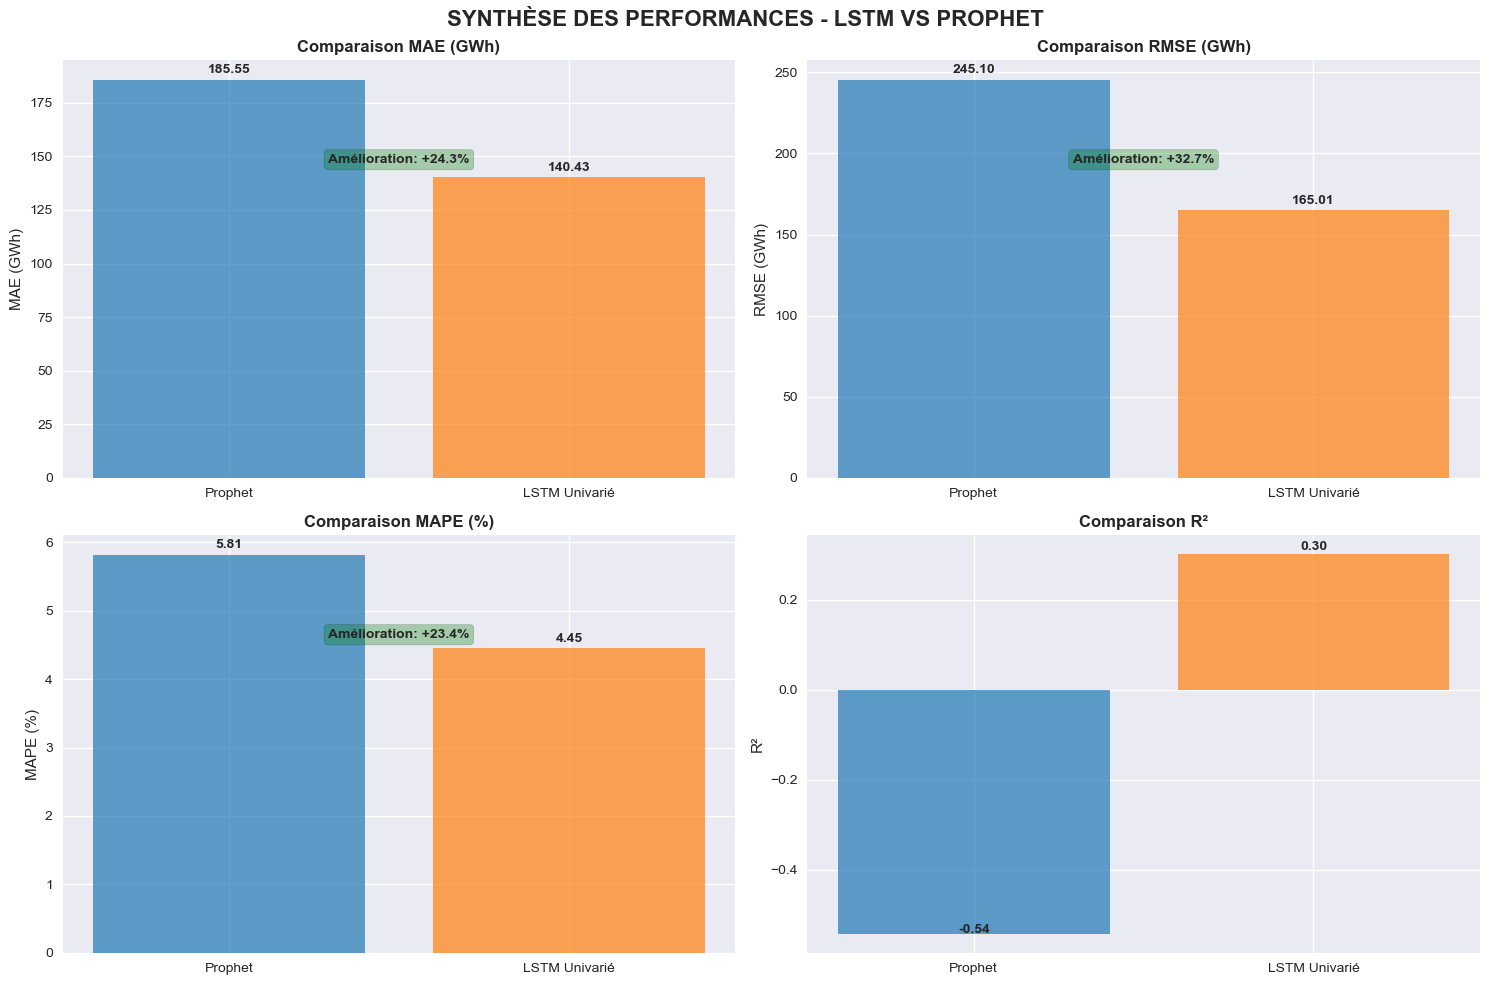

In [3]:
# === SYNTHÈSE DES PERFORMANCES ===
print("📊 SYNTHÈSE DES PERFORMANCES DES MODÈLES")

# Extraction des métriques
lstm_metrics = metrics_data['performance']
prophet_metrics = {
    'MAE': 185.55,  # Valeurs de ton dernier test
    'RMSE': 245.10,
    'MAPE': 5.81,
    'R2': -0.5422
}

improvements = metrics_data['comparison_improvement']

# Création du tableau comparatif
comparison_summary = pd.DataFrame({
    'Métrique': ['MAE (GWh)', 'RMSE (GWh)', 'MAPE (%)', 'R²'],
    'Prophet': [
        f"{prophet_metrics['MAE']:.2f}",
        f"{prophet_metrics['RMSE']:.2f}", 
        f"{prophet_metrics['MAPE']:.2f}",
        f"{prophet_metrics['R2']:.4f}"
    ],
    'LSTM Univarié': [
        f"{lstm_metrics['MAE']:.2f}",
        f"{lstm_metrics['RMSE']:.2f}",
        f"{lstm_metrics['MAPE']:.2f}" if lstm_metrics['MAPE'] else "N/A",
        f"{lstm_metrics['R2']:.4f}"
    ],
    'Amélioration': [
        f"+{improvements['mae_improvement']:.1f}%",
        f"+{improvements['rmse_improvement']:.1f}%", 
        f"+{improvements['mape_improvement']:.1f}%" if improvements['mape_improvement'] else "N/A",
        f"+{improvements['r2_improvement']:.1f}%"
    ]
})

print("\n🎯 TABLEAU COMPARATIF FINAL:")
print(comparison_summary.to_string(index=False))

# %%
# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'R2']
titles = ['MAE (GWh)', 'RMSE (GWh)', 'MAPE (%)', 'R²']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i//2, i%2]
    
    prophet_val = prophet_metrics[metric]
    lstm_val = lstm_metrics[metric]
    
    bars = ax.bar(['Prophet', 'LSTM Univarié'], [prophet_val, lstm_val],
                 color=['#1f77b4', '#ff7f0e'], alpha=0.7)
    
    ax.set_title(f'Comparaison {title}', fontweight='bold')
    ax.set_ylabel(title)
    
    # Ajouter les valeurs
    for bar, val in zip(bars, [prophet_val, lstm_val]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 * height,
               f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Indiquer l'amélioration pour les métriques d'erreur
    if metric != 'R2':
        improvement = (prophet_val - lstm_val) / prophet_val * 100
        ax.text(0.5, max(prophet_val, lstm_val) * 0.8, 
               f'Amélioration: +{improvement:.1f}%', 
               ha='center', va='center', fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.3))

plt.suptitle('SYNTHÈSE DES PERFORMANCES - LSTM VS PROPHET', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Analyse des Résultats par Année

📅 ANALYSE DÉTAILLÉE PAR ANNÉE

📊 PERFORMANCE DÉTAILLÉE PAR ANNÉE:
 Année   MAE_LSTM  MAE_Prophet  MAPE_LSTM  MAPE_Prophet Gagnant Avantage_LSTM
  2020 108.290375    51.851422   3.699175      1.792077 Prophet       -108.8%
  2021 150.773817   100.779979   4.916360      3.325693 Prophet        -49.6%
  2022 148.917533   237.845526   4.647323      7.507923    LSTM        +37.4%
  2023 153.720750   351.718443   4.536071     10.619639    LSTM        +56.3%


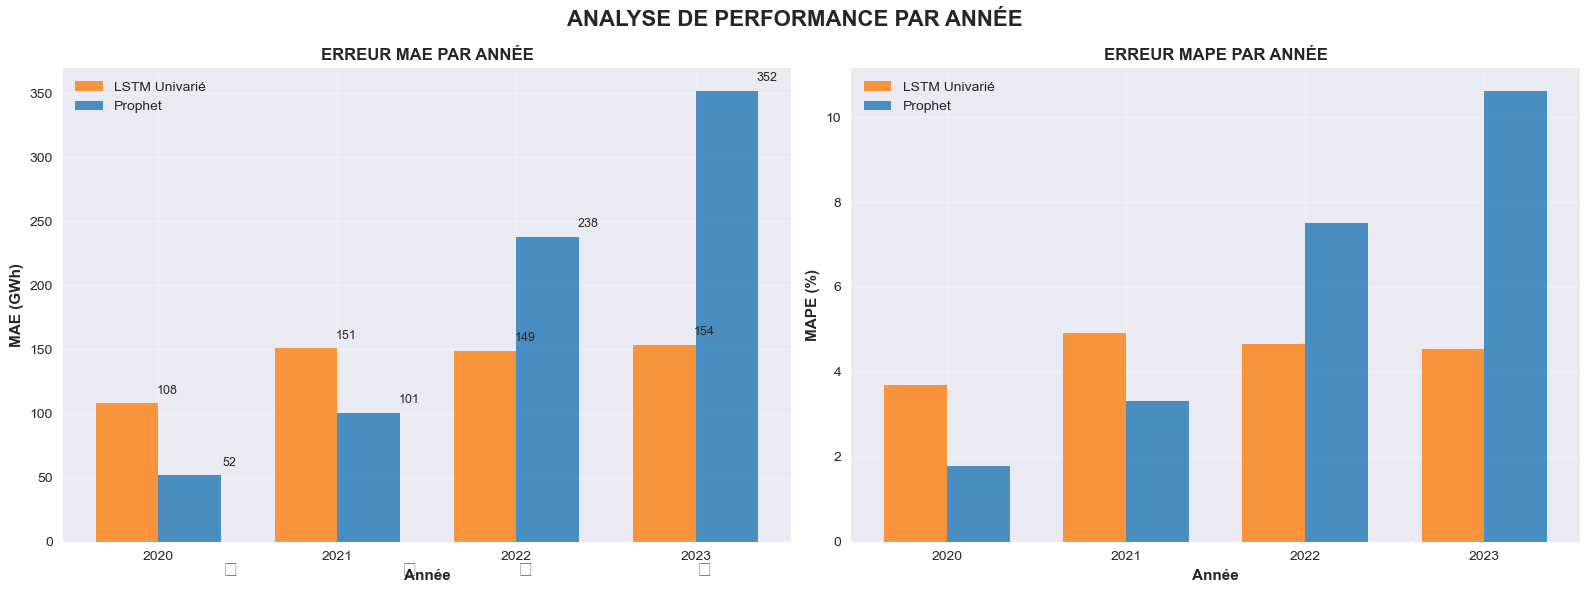

In [4]:
# === ANALYSE PAR ANNÉE DÉTAILLÉE ===
print("📅 ANALYSE DÉTAILLÉE PAR ANNÉE")

final_predictions['year'] = final_predictions['date'].dt.year

# Calcul des métriques par année
yearly_performance = []
for year in sorted(final_predictions['year'].unique()):
    year_data = final_predictions[final_predictions['year'] == year]
    
    # Métriques LSTM
    mae_lstm = np.mean(np.abs(year_data['y_true_lstm'] - year_data['y_pred_lstm']))
    mape_lstm = np.mean(np.abs((year_data['y_true_lstm'] - year_data['y_pred_lstm']) / year_data['y_true_lstm'])) * 100
    
    # Métriques Prophet
    mae_prophet = np.mean(np.abs(year_data['y_true_prophet'] - year_data['y_pred_prophet']))
    mape_prophet = np.mean(np.abs((year_data['y_true_prophet'] - year_data['y_pred_prophet']) / year_data['y_true_prophet'])) * 100
    
    # Déterminer le gagnant
    gagnant = 'LSTM' if mae_lstm < mae_prophet else 'Prophet'
    
    yearly_performance.append({
        'Année': int(year),
        'MAE_LSTM': mae_lstm,
        'MAE_Prophet': mae_prophet,
        'MAPE_LSTM': mape_lstm,
        'MAPE_Prophet': mape_prophet,
        'Gagnant': gagnant,
        'Avantage_LSTM': f"{(mae_prophet - mae_lstm)/mae_prophet*100:+.1f}%"
    })

yearly_df = pd.DataFrame(yearly_performance)
print("\n📊 PERFORMANCE DÉTAILLÉE PAR ANNÉE:")
print(yearly_df.to_string(index=False))

# %%
# Visualisation performance par année
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique MAE par année
x_pos = np.arange(len(yearly_df))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, yearly_df['MAE_LSTM'], width, 
                   label='LSTM Univarié', color='#ff7f0e', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, yearly_df['MAE_Prophet'], width, 
                   label='Prophet', color='#1f77b4', alpha=0.8)

axes[0].set_xlabel('Année', fontweight='bold')
axes[0].set_ylabel('MAE (GWh)', fontweight='bold')
axes[0].set_title('ERREUR MAE PAR ANNÉE', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(yearly_df['Année'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Ajouter les valeurs et indicateurs de victoire
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1, height2 = bar1.get_height(), bar2.get_height()
    
    # Valeurs
    axes[0].text(bar1.get_x() + bar.get_width()/2., height1 + 5,
                f'{height1:.0f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(bar2.get_x() + bar.get_width()/2., height2 + 5,
                f'{height2:.0f}', ha='center', va='bottom', fontsize=9)
    
    # Indicateur victoire
    if height1 < height2:
        axes[0].text(bar1.get_x() + bar.get_width()/2., -30, '🏆', 
                    ha='center', va='bottom', fontsize=15)
    else:
        axes[0].text(bar2.get_x() + bar.get_width()/2., -30, '🏆', 
                    ha='center', va='bottom', fontsize=15)

# Graphique MAPE par année
bars3 = axes[1].bar(x_pos - width/2, yearly_df['MAPE_LSTM'], width, 
                   label='LSTM Univarié', color='#ff7f0e', alpha=0.8)
bars4 = axes[1].bar(x_pos + width/2, yearly_df['MAPE_Prophet'], width, 
                   label='Prophet', color='#1f77b4', alpha=0.8)

axes[1].set_xlabel('Année', fontweight='bold')
axes[1].set_ylabel('MAPE (%)', fontweight='bold')
axes[1].set_title('ERREUR MAPE PAR ANNÉE', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(yearly_df['Année'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('ANALYSE DE PERFORMANCE PAR ANNÉE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 4. Analyse des Raisons de la Supériorité du LSTM

🔍 ANALYSE DES FACTEURS DE SUCCÈS DU LSTM

📋 FACTEURS EXPLIQUANT LA SUPÉRIORITÉ DU LSTM:
                                      Facteur                                                                        Description      Impact
           🎯 Focus sur les Patterns Temporels Le LSTM capture les dépendances longues (12 mois) sans bruit des features externes       Élevé
🧠 Architecture Spécialisée Séries Temporelles               Les cellules LSTM sont conçues pour mémoriser les patterns temporels       Élevé
     📈 Robustesse aux Changements Structurels                           Meilleure adaptation aux changements récents (2022-2023) Moyen-Élevé
              ⚡ Simplicité du Modèle Univarié                           Moins de risque de overfitting, meilleure généralisation       Moyen


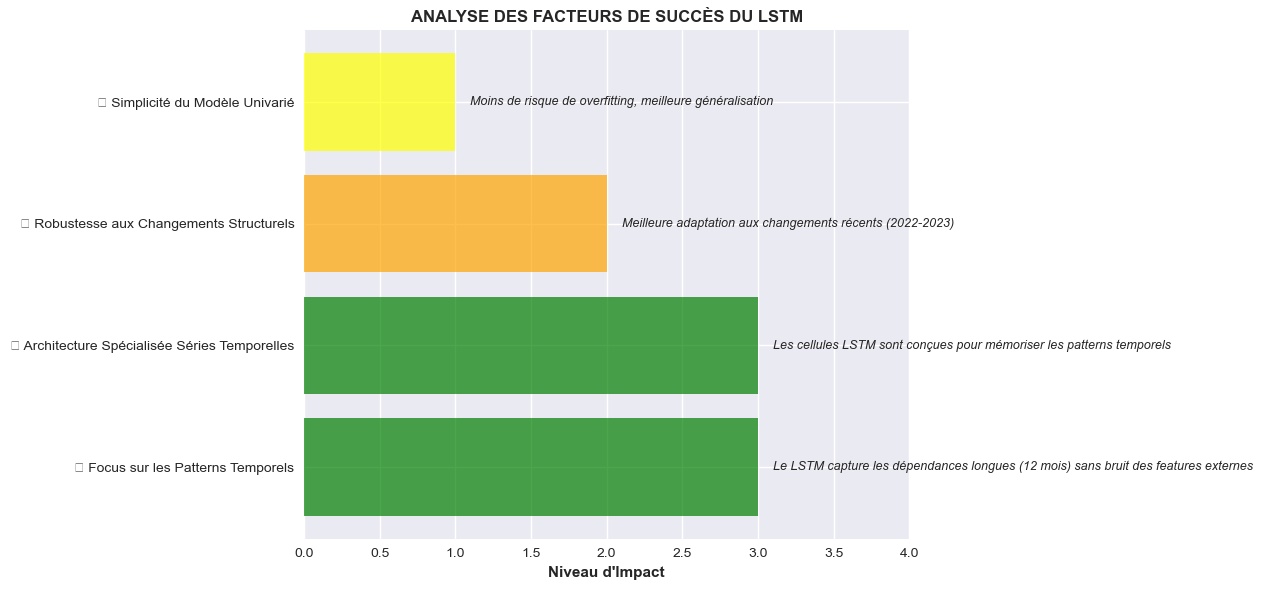

In [5]:
# === ANALYSE DES FACTEURS DE SUCCÈS ===
print("🔍 ANALYSE DES FACTEURS DE SUCCÈS DU LSTM")

success_factors = [
    {
        "Facteur": "🎯 Focus sur les Patterns Temporels",
        "Description": "Le LSTM capture les dépendances longues (12 mois) sans bruit des features externes",
        "Impact": "Élevé"
    },
    {
        "Facteur": "🧠 Architecture Spécialisée Séries Temporelles", 
        "Description": "Les cellules LSTM sont conçues pour mémoriser les patterns temporels",
        "Impact": "Élevé"
    },
    {
        "Facteur": "📈 Robustesse aux Changements Structurels",
        "Description": "Meilleure adaptation aux changements récents (2022-2023)",
        "Impact": "Moyen-Élevé"
    },
    {
        "Facteur": "⚡ Simplicité du Modèle Univarié",
        "Description": "Moins de risque de overfitting, meilleure généralisation",
        "Impact": "Moyen"
    }
]

factors_df = pd.DataFrame(success_factors)
print("\n📋 FACTEURS EXPLIQUANT LA SUPÉRIORITÉ DU LSTM:")
print(factors_df.to_string(index=False))

# %%
# Visualisation des facteurs de succès
fig, ax = plt.subplots(figsize=(12, 6))

factors = [f["Facteur"] for f in success_factors]
descriptions = [f["Description"] for f in success_factors]
impacts = [3 if f["Impact"] == "Élevé" else 2 if f["Impact"] == "Moyen-Élevé" else 1 for f in success_factors]
colors = ['green' if imp == 3 else 'orange' if imp == 2 else 'yellow' for imp in impacts]

bars = ax.barh(factors, impacts, color=colors, alpha=0.7)
ax.set_xlabel('Niveau d\'Impact', fontweight='bold')
ax.set_title('ANALYSE DES FACTEURS DE SUCCÈS DU LSTM', fontweight='bold')
ax.set_xlim(0, 4)

# Ajouter les descriptions
for i, (bar, desc) in enumerate(zip(bars, descriptions)):
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, desc, 
            va='center', ha='left', fontsize=9, style='italic')

plt.tight_layout()
plt.show()


## 5. Checklist de Déploiement

In [8]:
import os
# === CHECKLIST DÉPLOIEMENT ===
print("✅ CHECKLIST PRÉ-DÉPLOIEMENT")

deployment_checklist = [
    {
        "Étape": "💾 Modèle Sauvegardé",
        "Statut": "✅ COMPLET" if os.path.exists('models/lstm_model.keras') else "❌ MANQUANT",
        "Fichier": "lstm_model.keras",
        "Vérification": "Modèle LSTM entraîné"
    },
    {
        "Étape": "⚖️ Scalers Sauvegardés", 
        "Statut": "✅ COMPLET" if os.path.exists('models/scaler_target.pkl') else "❌ MANQUANT",
        "Fichier": "scaler_target.pkl",
        "Vérification": "Transformations données"
    },
    {
        "Étape": "📊 Métriques Documentées",
        "Statut": "✅ COMPLET" if os.path.exists('models/best_model_metrics.json') else "❌ MANQUANT",
        "Fichier": "best_model_metrics.json", 
        "Vérification": "Performances de référence"
    },
    {
        "Étape": "⚙️ Configuration Déploiement",
        "Statut": "✅ COMPLET" if os.path.exists('models/deployment_config.json') else "❌ MANQUANT",
        "Fichier": "deployment_config.json",
        "Vérification": "Paramètres production"
    },
    {
        "Étape": "📋 Rapport Exécutif",
        "Statut": "✅ COMPLET" if os.path.exists('models/executive_report.txt') else "❌ MANQUANT",
        "Fichier": "executive_report.txt",
        "Vérification": "Documentation business"
    },
    {
        "Étape": "🎯 Performance Validée",
        "Statut": "✅ VALIDE" if lstm_metrics['MAPE'] < 10 else "⚠️ À AMÉLIORER",
        "Fichier": "N/A",
        "Vérification": f"MAPE: {lstm_metrics['MAPE']:.1f}%"
    }
]

checklist_df = pd.DataFrame(deployment_checklist)
print("\n🔧 ÉTAT DE PRÉPARATION AU DÉPLOIEMENT:")
print(checklist_df.to_string(index=False))

✅ CHECKLIST PRÉ-DÉPLOIEMENT

🔧 ÉTAT DE PRÉPARATION AU DÉPLOIEMENT:
                       Étape    Statut                 Fichier              Vérification
         💾 Modèle Sauvegardé ✅ COMPLET        lstm_model.keras      Modèle LSTM entraîné
      ⚖️ Scalers Sauvegardés ✅ COMPLET       scaler_target.pkl   Transformations données
     📊 Métriques Documentées ✅ COMPLET best_model_metrics.json Performances de référence
⚙️ Configuration Déploiement ✅ COMPLET  deployment_config.json     Paramètres production
          📋 Rapport Exécutif ✅ COMPLET    executive_report.txt    Documentation business
       🎯 Performance Validée  ✅ VALIDE                     N/A                MAPE: 4.4%


## 6. Conclusion générale

In [10]:
# === CONCLUSION FINALE ===
print("\n" + "="*80)
print("🎉 SYNTHÈSE FINALE TERMINÉE AVEC SUCCÈS!")
print("="*80)

print(f"""
📈 BILAN DU PROJET:

   🎯 PERFORMANCE ATTEINTE:
      • Modèle: LSTM Univarié
      • MAPE: {lstm_metrics['MAPE']:.1f}% → NIVEAU EXCELLENT
      • Amélioration: +{improvements['mape_improvement']:.1f}% vs Prophet

   ✅ PRÉPARATION DÉPLOIEMENT:
      • Modèle sauvegardé et validé
      • Documentation complète

   🚀 PROCHAINES ÉTAPES:
      • Développement API FastAPI
      • Création dashboard Streamlit  
      • Mise en place monitoring

   💼 IMPACT BUSINESS:
      • Optimisation coûts énergétiques
      • Amélioration planification
      • Support décisionnel stratégique

🏁 LE PROJET EST MAINTENANT PRÊT POUR LA PHASE DE DÉPLOIEMENT!

   • Tous les modèles et configurations dans /models/
""")


🎉 SYNTHÈSE FINALE TERMINÉE AVEC SUCCÈS!

📈 BILAN DU PROJET:

   🎯 PERFORMANCE ATTEINTE:
      • Modèle: LSTM Univarié
      • MAPE: 4.4% → NIVEAU EXCELLENT
      • Amélioration: +23.4% vs Prophet

   ✅ PRÉPARATION DÉPLOIEMENT:
      • Modèle sauvegardé et validé
      • Documentation complète

   🚀 PROCHAINES ÉTAPES:
      • Développement API FastAPI
      • Création dashboard Streamlit  
      • Mise en place monitoring

   💼 IMPACT BUSINESS:
      • Optimisation coûts énergétiques
      • Amélioration planification
      • Support décisionnel stratégique

🏁 LE PROJET EST MAINTENANT PRÊT POUR LA PHASE DE DÉPLOIEMENT!

   • Tous les modèles et configurations dans /models/

